In [1]:
# run setup for notebook
%load_ext rpy2.ipython
%config InlineBackend.figure_format='retina'

In [2]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import gpflow as gf
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

2025-11-21 05:46:49.173495: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 05:46:49.173917: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 05:46:49.209875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 05:46:50.977825: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Generate data to fit.

In [3]:
# x axis values
x = np.linspace(start = 0, stop = 2 * np.pi, num = 100)

# random noise
rng = np.random.default_rng()

# divide by 5 so that the sine wave is still readable
noise = rng.normal(size = 100) / 4

# y is sin(x) plus random noise
y = np.sin(x) + noise

In [4]:
# make the variables into tensors for compatibility below
# also need to shape them into column vectors
x_tensor = tf.convert_to_tensor(x.reshape(100, 1) , dtype = "float64")
y_tensor = tf.convert_to_tensor(y.reshape(100, 1), dtype = "float64")

2025-11-21 05:46:53.179039: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Plot the data.

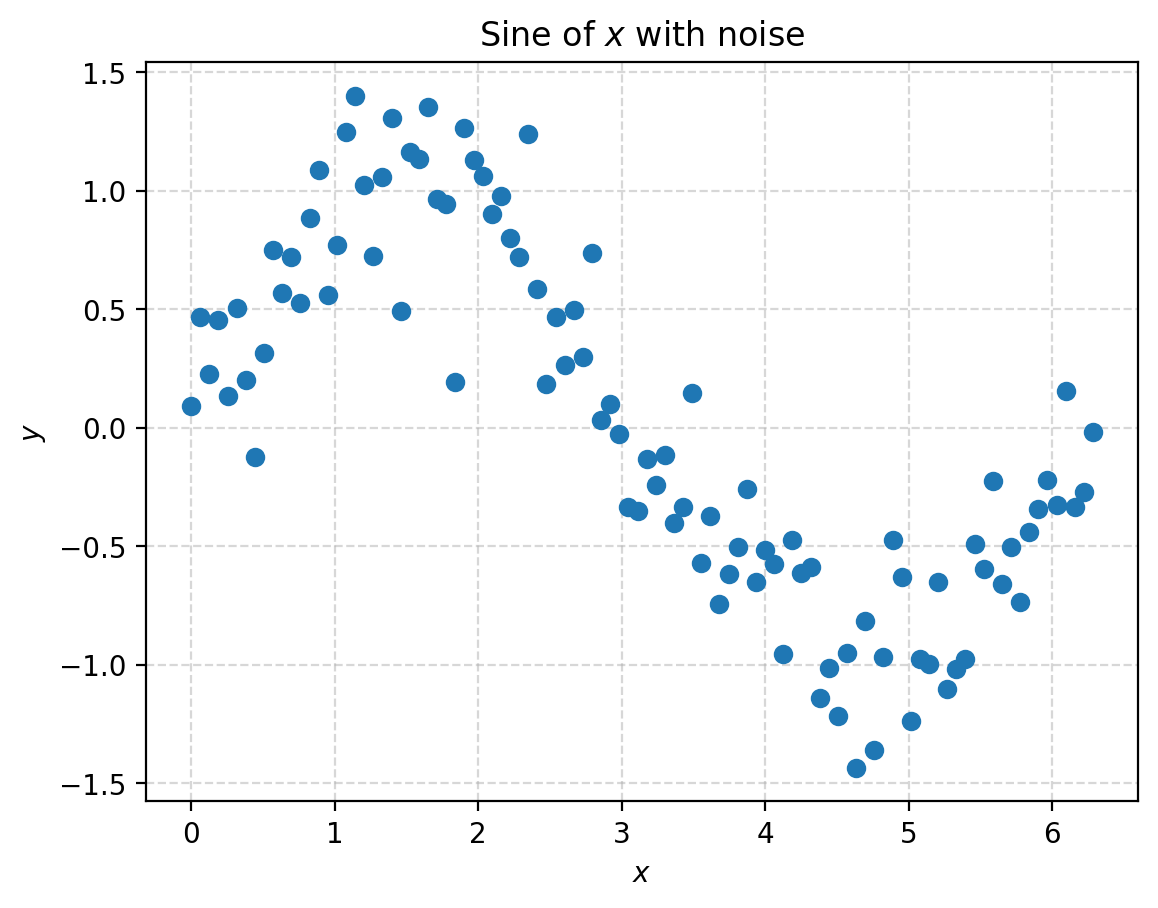

In [5]:
fig, ax = plt.subplots()
ax.scatter(x, y, zorder = 2)
ax.grid(True, alpha = 0.5, linestyle = "--")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Sine of $x$ with noise")
plt.show()

Initialize a GP regression model.

In [6]:
# initialize the kernel and likelihood
se_kernel = gf.kernels.SquaredExponential()
gaus_likelihood = gf.likelihoods.Gaussian()

# remove the transforms from the variables
se_kernel.variance = gf.Parameter(value = 1, transform = None)
se_kernel.lengthscales = gf.Parameter(value = 1, transform = None)

gaus_likelihood.variance = gf.Parameter(value = 1, transform = None)

Print the kernel and likelihood.

In [7]:
se_kernel

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Identity,,True,(),float64,1
SquaredExponential.lengthscales,Parameter,Identity,,True,(),float64,1


In [8]:
gaus_likelihood

name,class,transform,prior,trainable,shape,dtype,value
Gaussian.variance,Parameter,Identity,,True,(),float64,1


We can see from the output above that the default transforms (Softplus) have been removed.

Now we can assess how this identity transform affects model fitting.

In [9]:
# initialize the model
se_model = gf.models.GPR(
    data = (x.reshape(100,1), y.reshape(100,1)),
    kernel = se_kernel,
    likelihood = gaus_likelihood
)

Optimize the model using the conjugate gradient method.

Below fails with error.

In [10]:
optimizer = gf.optimizers.Scipy()
optimizer.minimize(
    
    # a closure that re-evaluates the model, returning the loss to be minimized.
    closure = se_model.training_loss,
    
    # the list (tuple) of variables to be optimized
    variables = se_model.trainable_variables,
    
    method = "CG"
)

2025-11-21 05:46:54.851817: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-11-21 05:46:54.855485: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-11-21 05:46:54.858345: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-11-21 05:46:54.861204: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-11-21 05:46:54.864013: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular out

 message: NaN result encountered.
 success: False
  status: 3
     fun: nan
       x: [ 9.329e+01 -4.575e+01 -1.028e+03]
     nit: 1
     jac: [       nan        nan        nan]
    nfev: 112
    njev: 112

We see that without the transform, the optimization fails. Let's reset the kernel and likelihood trainable variables, but rather than use transforms, let us set priors on the variables to ensure that values remain appropriate during training.

Generate a half normal distribution.

In [11]:
half_normal = tfd.HalfNormal(
    # default float is tf.float64
    scale = gf.utilities.to_default_float(30)
)

In [12]:
# confirm that float64 is generated
half_normal.sample(10)

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 2.73090315, 57.78397262, 18.77490241, 11.27613563, 66.03074278,
       25.46212717,  4.34185938, 32.35679203, 13.24516974,  0.37186332])>

Plot the density.

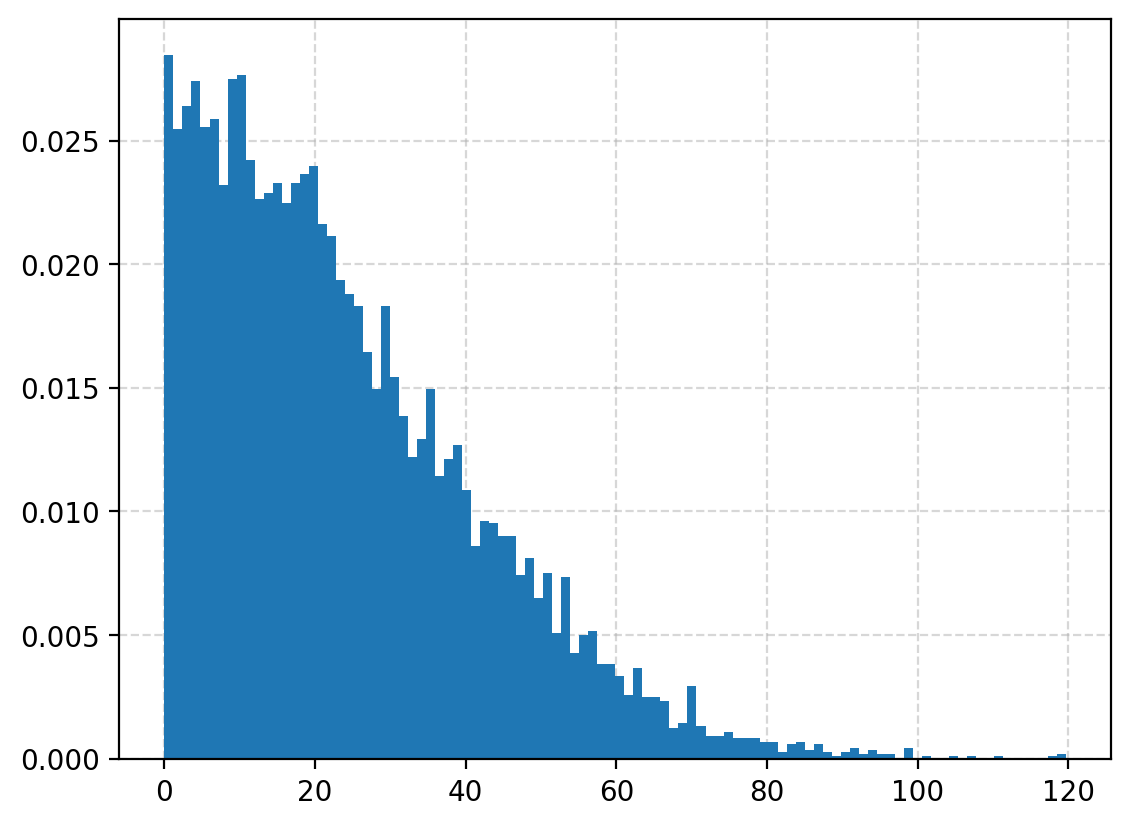

In [13]:
fig, ax = plt.subplots()
ax.hist(half_normal.sample(10000), density = True, bins = 100, zorder = 2)
ax.grid(True, alpha = 0.5, linestyle = "--")
plt.show()

Use the generated half normal distribution as the prior on the parameters.

In [14]:
# initialize the kernel and likelihood
se_kernel = gf.kernels.SquaredExponential()
gaus_likelihood = gf.likelihoods.Gaussian()

# remove the transforms from the variables
se_kernel.variance = gf.Parameter(
    value = 1, 
    transform = None, 
    prior = half_normal, 
    prior_on = "unconstrained"
)

se_kernel.lengthscales = gf.Parameter(
    value = 1, 
    transform = None, 
    prior = half_normal, 
    prior_on = "unconstrained"
)

gaus_likelihood.variance = gf.Parameter(
    value = 1, 
    transform = None, 
    prior = half_normal, 
    prior_on = "unconstrained"
)

Print the kernel and likelihood.

In [15]:
se_kernel

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Identity,HalfNormal,True,(),float64,1
SquaredExponential.lengthscales,Parameter,Identity,HalfNormal,True,(),float64,1


In [16]:
gaus_likelihood

name,class,transform,prior,trainable,shape,dtype,value
Gaussian.variance,Parameter,Identity,HalfNormal,True,(),float64,1


Fit the model.

Below fails with error.

In [17]:
# initialize the model
se_model = gf.models.GPR(
    data = (x_tensor, y_tensor),
    kernel = se_kernel,
    likelihood = gaus_likelihood
)

optimizer.minimize(
    
    # a closure that re-evaluates the model, returning the loss to be minimized.
    closure = se_model.training_loss,
    
    # the list (tuple) of variables to be optimized
    variables = se_model.trainable_variables,
    
    method = "CG"
)

2025-11-21 05:46:55.557363: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-11-21 05:46:55.560675: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-11-21 05:46:55.563624: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-11-21 05:46:55.565961: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2025-11-21 05:46:55.567960: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular out

 message: NaN result encountered.
 success: False
  status: 3
     fun: nan
       x: [ 9.326e+01 -4.578e+01 -1.028e+03]
     nit: 1
     jac: [       nan        nan        nan]
    nfev: 112
    njev: 112

The above still breaks even though the priors restrict the values of the trainable variables to positive reals. This occurs whether the prior is set on the constrained or unconstrained parameter values. In order for the  code to run correctly, the transform needs to remain.

In [18]:
# initialize the kernel and likelihood
se_kernel = gf.kernels.SquaredExponential()
gaus_likelihood = gf.likelihoods.Gaussian()

# DO NOT REMOVE THE TRANSFORMS
# add the priors
se_kernel.variance.prior = half_normal
se_kernel.lengthscales.prior = half_normal

gaus_likelihood.variance.prior = half_normal

Print the kernel and likelihood.

In [19]:
se_kernel

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,HalfNormal,True,(),float64,1
SquaredExponential.lengthscales,Parameter,Softplus,HalfNormal,True,(),float64,1


In [20]:
gaus_likelihood

name,class,transform,prior,trainable,shape,dtype,value
Gaussian.variance,Parameter,Softplus + Shift,HalfNormal,True,(),float64,1


In [21]:
# initialize the model
se_model = gf.models.GPR(
    data = (x_tensor, y_tensor),
    kernel = se_kernel,
    likelihood = gaus_likelihood
)

optimizer.minimize(
    
    # a closure that re-evaluates the model, returning the loss to be minimized.
    closure = se_model.training_loss,
    
    # the list (tuple) of variables to be optimized
    variables = se_model.trainable_variables,
    
    method = "CG"
)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 29.537379565795803
       x: [ 8.367e-01 -6.660e-01 -2.687e+00]
     nit: 13
     jac: [ 3.934e-06 -3.330e-06  1.932e-06]
    nfev: 34
    njev: 34

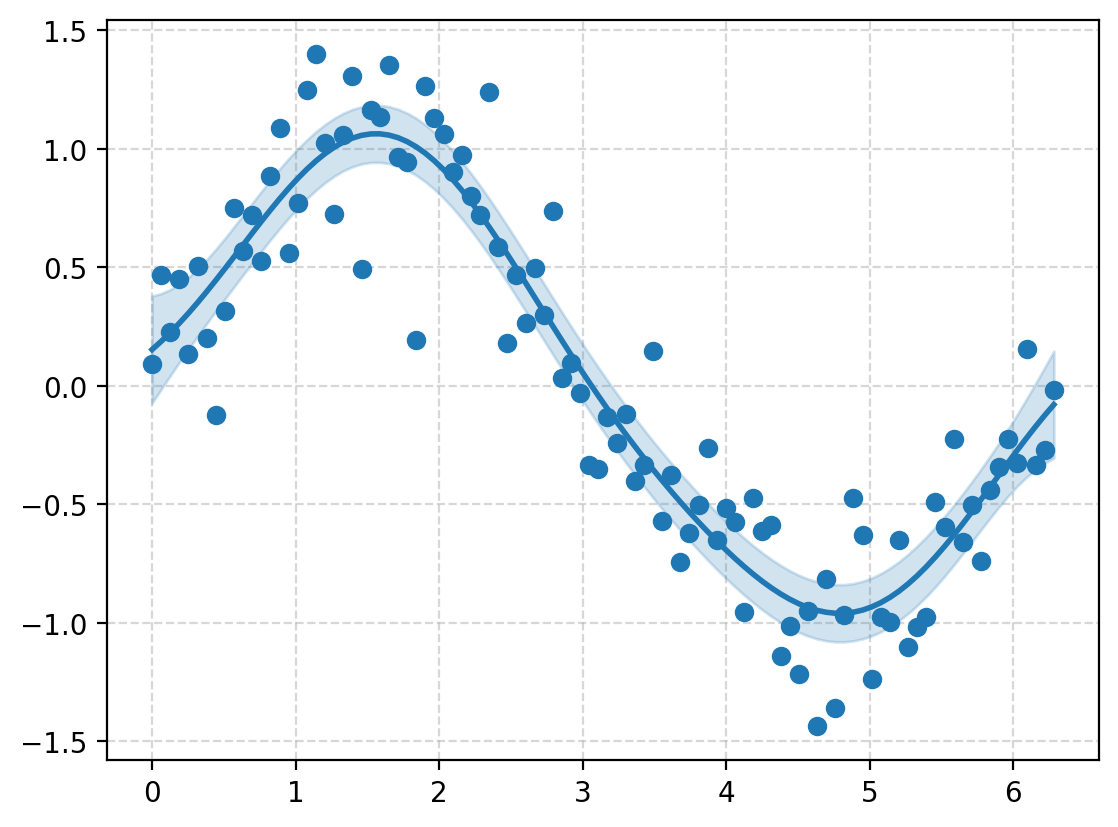

In [22]:
xx = np.linspace(0, 2 * np.pi, 100).reshape(100,1)
mean, var = se_model.predict_f(xx)

fig, ax = plt.subplots()
ax.scatter(x, y, zorder = 2)
ax.plot(xx, mean, lw = 2)
ax.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color = 'C0',
    alpha = 0.2,
    zorder = 2
)
ax.grid(True, alpha = 0.5, linestyle = "--")

In [23]:
se_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,HalfNormal,True,(),float64,0.414613
GPR.kernel.lengthscales,Parameter,Softplus,HalfNormal,True,(),float64,1.19658
GPR.likelihood.variance,Parameter,Softplus + Shift,HalfNormal,True,(),float64,0.0658416


In [24]:
se_model.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-18.655520010598167>

In [25]:
# initialize the model with no constraints
se_model = gf.models.GPR(
    data = (x_tensor, y_tensor),
    kernel = gf.kernels.SquaredExponential(),
    likelihood = gf.likelihoods.Gaussian()
)

optimizer.minimize(
    
    # a closure that re-evaluates the model, returning the loss to be minimized.
    closure = se_model.training_loss,
    
    # the list (tuple) of variables to be optimized
    variables = se_model.trainable_variables,
    
    method = "CG"
)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 18.65551991583345
       x: [ 8.369e-01 -6.657e-01 -2.687e+00]
     nit: 12
     jac: [ 9.833e-06 -2.974e-06  6.535e-06]
    nfev: 32
    njev: 32

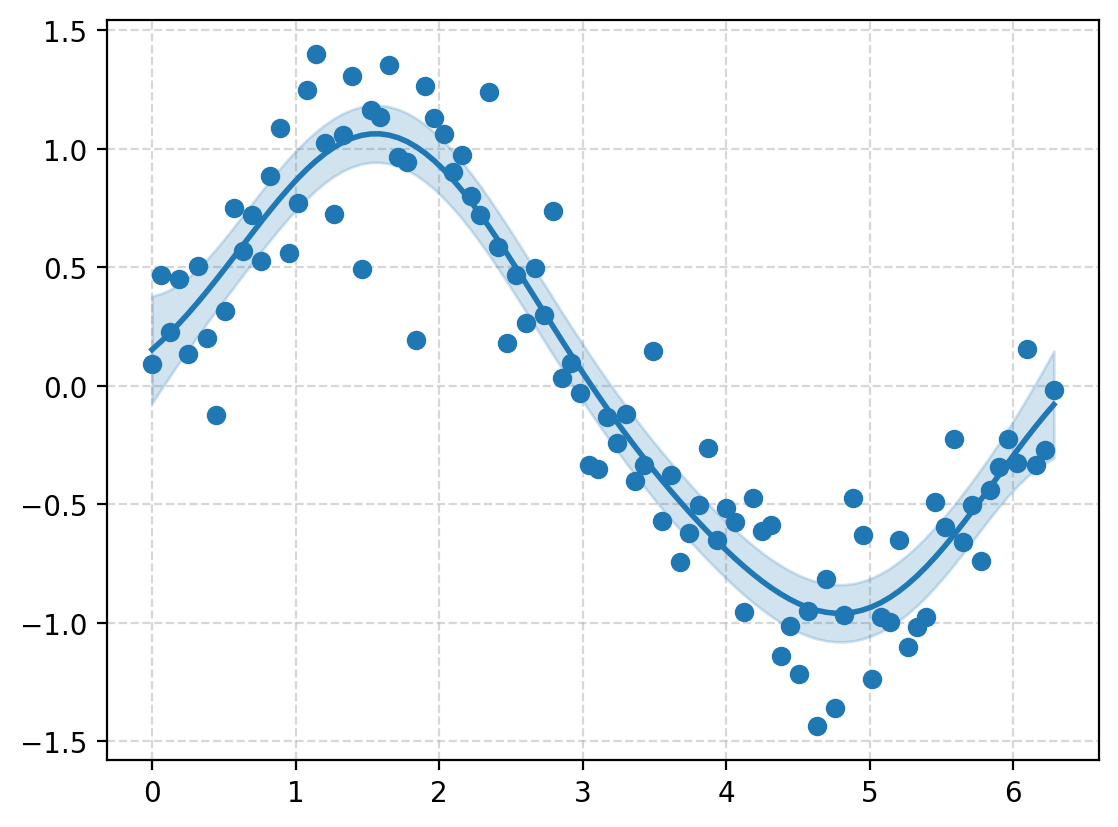

In [26]:
xx = np.linspace(0, 2 * np.pi, 100).reshape(100,1)
mean, var = se_model.predict_f(xx)

fig, ax = plt.subplots()
ax.scatter(x, y, zorder = 2)
ax.plot(xx, mean, lw = 2)
ax.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color = 'C0',
    alpha = 0.2,
    zorder = 2
)
ax.grid(True, alpha = 0.5, linestyle = "--")

In [27]:
se_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.414704
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.19669
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0658419


In [28]:
se_model.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-18.65551991583345>

Bad model to see how much `log_marginal_likelihood` changes.

In [29]:
# initialize the model with variables that cannot be trained
se_kernel = gf.kernels.SquaredExponential()
se_kernel.variance = gf.Parameter(value = 0.1, trainable = False)
se_kernel.lengthscales = gf.Parameter(value = 0.1, trainable = False)

se_model = gf.models.GPR(
    data = (x_tensor, y_tensor),
    kernel = se_kernel,
    likelihood = gf.likelihoods.Gaussian()
)

In [30]:
se_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Identity,,False,(),float64,0.1
GPR.kernel.lengthscales,Parameter,Identity,,False,(),float64,0.1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


In [31]:
optimizer.minimize(
    
    # a closure that re-evaluates the model, returning the loss to be minimized.
    closure = se_model.training_loss,
    
    # the list (tuple) of variables to be optimized
    variables = se_model.trainable_variables,
    
    method = "CG"
)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 73.07405505516552
       x: [-2.641e+00]
     nit: 5
     jac: [ 5.663e-08]
    nfev: 13
    njev: 13

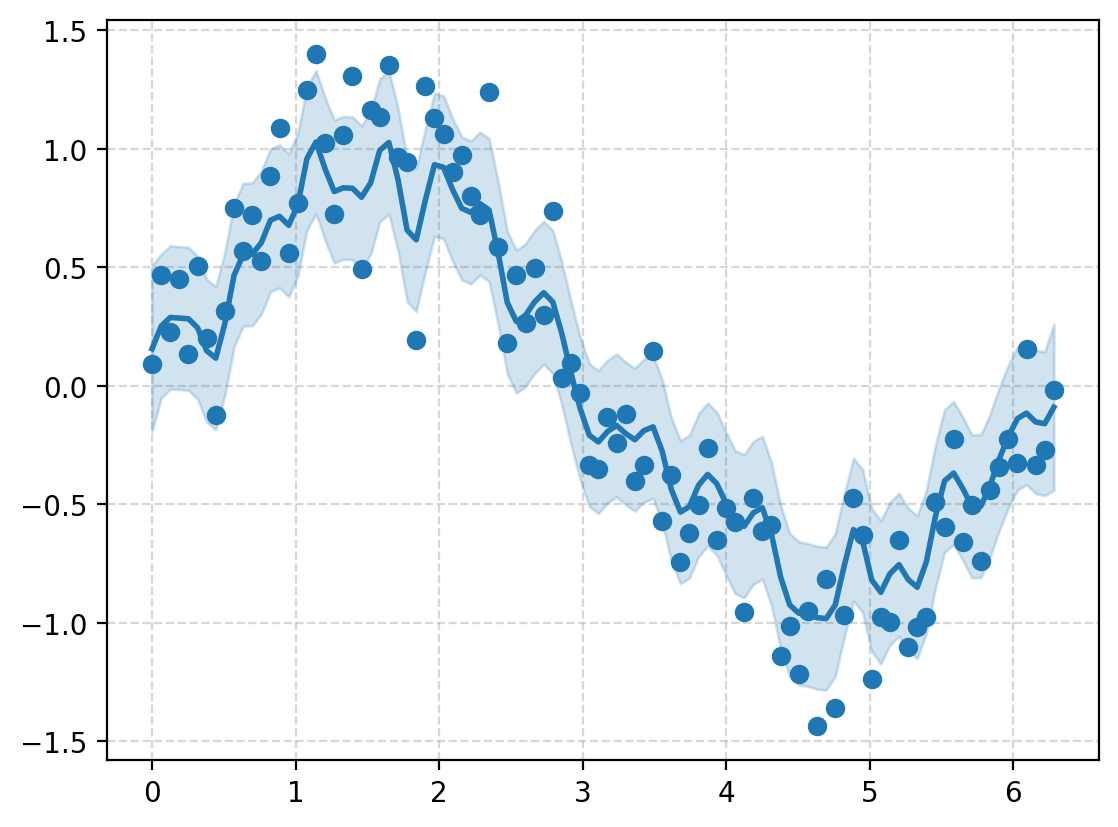

In [32]:
xx = np.linspace(0, 2 * np.pi, 100).reshape(100,1)
mean, var = se_model.predict_f(xx)

fig, ax = plt.subplots()
ax.scatter(x, y, zorder = 2)
ax.plot(xx, mean, lw = 2)
ax.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color = 'C0',
    alpha = 0.2,
    zorder = 2
)
ax.grid(True, alpha = 0.5, linestyle = "--")

In [33]:
se_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Identity,,False,(),float64,0.1
GPR.kernel.lengthscales,Parameter,Identity,,False,(),float64,0.1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0688554


In [34]:
se_model.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-73.07405505516552>

# Different covariance functions

In [35]:
m32_kernel = gf.kernels.Matern32()
m32_model = gf.models.GPR(
    data = (x_tensor, y_tensor),
    kernel = m32_kernel,
    likelihood = gf.likelihoods.Gaussian()
)

In [36]:
m32_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


In [37]:
optimizer.minimize(
    
    # a closure that re-evaluates the model, returning the loss to be minimized.
    closure = m32_model.training_loss,
    
    # the list (tuple) of variables to be optimized
    variables = m32_model.trainable_variables,
    
    method = "CG"
)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 19.877780524164706
       x: [ 1.834e+00 -4.698e-01 -2.710e+00]
     nit: 13
     jac: [ 2.647e-06  3.013e-06 -2.223e-06]
    nfev: 31
    njev: 31

Print the trained values.

In [38]:
m32_model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.485581
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.9821
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0644371


Print the `log_marginal_likelihood`.

In [39]:
m32_model.log_marginal_likelihood()

<tf.Tensor: shape=(), dtype=float64, numpy=-19.877780524164706>

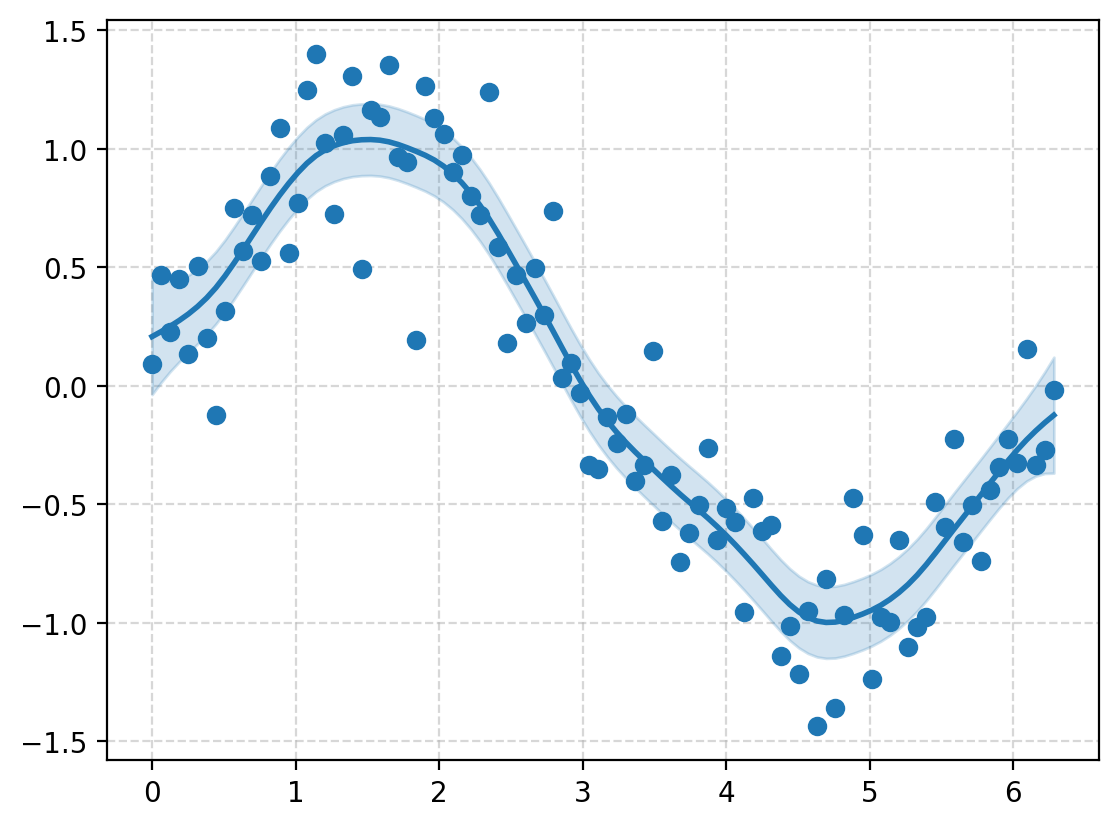

In [40]:
xx = np.linspace(0, 2 * np.pi, 100).reshape(100,1)
mean, var = m32_model.predict_f(xx)

fig, ax = plt.subplots()
ax.scatter(x, y, zorder = 2)
ax.plot(xx, mean, lw = 2)
ax.fill_between(
    xx[:,0],
    mean[:,0] - 1.96 * np.sqrt(var[:,0]),
    mean[:,0] + 1.96 * np.sqrt(var[:,0]),
    color = 'C0',
    alpha = 0.2,
    zorder = 2
)
ax.grid(True, alpha = 0.5, linestyle = "--")

The above function appears less smooth than when the squared exponential is used, which is expected.